In [1]:
import cv2
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import matplotlib
matplotlib.rcParams.update({'font.size':6})

In [8]:
nPosts = 2
symmetric = False

df = pd.read_csv("/Users/vivekhsridhar/Documents/Work/Results/decision_geometry/Data/Theory/SPP/flydata_n" + str(nPosts) + ".csv")
df.head()

,replicate,time,good_run,x,y,cue_reached
0,0,0,1,500.228,499.868,-1
1,0,50,1,501.030,498.882,-1
2,0,100,1,502.548,498.315,-1
3,0,150,1,505.845,497.374,-1
4,0,200,1,510.193,497.128,-1


In [9]:
if symmetric:
    xs = np.array((df[' x'] - 500) / 100)
else:
    xs = np.array(df[' x'] / 100)
ys = np.array((df[' y'] - 500) / 100)

if nPosts == 2:
    if symmetric:
        post0_x = 5.0*np.cos(np.pi)
        post0_y = 5.0*np.sin(np.pi)

        post1_x = 5.0*np.cos(0)
        post1_y = 5.0*np.sin(0)
    else:
        post0_x = 5.0*np.cos(np.pi/6)
        post0_y = -5.0*np.sin(np.pi/6)

        post1_x = 5.0*np.cos(np.pi/6)
        post1_y = 5.0*np.sin(np.pi/6)
else:
    if symmetric:
        post0_x = 5.0*np.cos(-2*np.pi/3)
        post0_y = 5.0*np.sin(-2*np.pi/3)

        post1_x = 5.0
        post1_y = 0.0

        post2_x = 5.0*np.cos(2*np.pi/3)
        post2_y = 5.0*np.sin(2*np.pi/3)
    else:
        post0_x = 5.0*np.cos(2*np.pi/9)
        post0_y = -5.0*np.sin(2*np.pi/9)

        post1_x = 5.0
        post1_y = 0.0

        post2_x = 5.0*np.cos(2*np.pi/9)
        post2_y = 5.0*np.sin(2*np.pi/9)

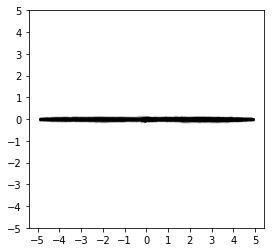

In [10]:
fig, ax = plt.subplots(1,1)
plt.scatter(xs, ys, c='black', s=1, alpha=0.1)
ax.set_aspect('equal')
if symmetric:
    if nPosts == 2:
        ax.set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
        ax.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
    else:
        ax.set_xticks([-2,-1,0,1,2,3,4,5])
        ax.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
else:
    if nPosts == 2:
        ax.set_xticks([0,1,2,3,4])
    else: 
        ax.set_xticks([0,1,2,3,4,5])
    
fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/trajectories_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')

In [11]:
nbins = 500
peak_threshold = 0.9

def density_map(x, y, stats=True):
    blur = (11, 11) if stats == True else (51, 51)
    
    if nPosts == 2:
        r = (
            [[-5, 5], [-5, 5]]
            if symmetric == True
            else [[0, post0_x], [post0_y, post1_y]]
        )
    else:
        r = (
            [[post0_x, post1_x], [post0_y, post2_y]]
            if symmetric == True
            else [[0, post1_x], [post0_y, post2_y]]
        )
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)

    if nPosts == 2:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))
    else:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    for i in range(0, nbins):
        max_val = np.nanmax(tmp_img[:, i])
        tmp_img[:, i] = tmp_img[:, i] / max_val if max_val > 0 else tmp_img[:, i]

    return tmp_img

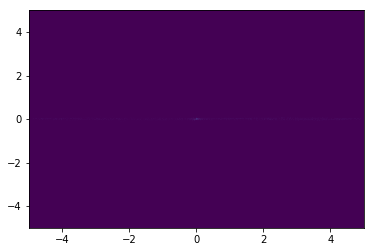

In [12]:
img = density_map(xs, ys, stats=False)

if nPosts == 2:
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
else:
    x_peaks = np.where(img > peak_threshold)[1] * post1_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

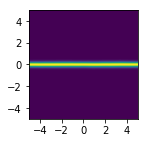

In [13]:
if nPosts == 2:
    if symmetric == True:
        fig, ax = plt.subplots(1,1, figsize=(2,2))
        plt.imshow(img, extent=[-5, 5, -5.0, 5.0])
        plt.xticks([-4,-2,0,2,4])
        plt.yticks([-4,-2,0,2,4])
    else:
        plt.imshow(img, extent=[0, post0_x, post0_y, post1_y])
else:
    if symmetric == True:
        fig, ax = plt.subplots(1,1, figsize=(3.75/2,post2_y/2))
        plt.imshow(img, extent=[post0_x, post1_x, post0_y, post2_y])
    else:
        plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

#fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/symmetric_density_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')

### Identify bifurcation point using a piecewise phase-transition function

#### Get first bifurcation point
Once you have this, you can draw a line segment bisecting the angle between the point and two targets. This will be the line about which you symmetrise to get the second bifurcation point

In [10]:
def fitfunc(x, p, q, r):
    if x < p:
        return 0
    else:
        return r * (np.abs((x - p)) ** q)

def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

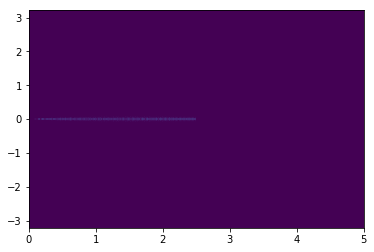

In [11]:
params1 = np.zeros((1, 3))

if nPosts == 2:
    x_fit = []
    y_fit = []

    x_sub = np.concatenate((xs, xs))
    y_sub = np.concatenate((ys, -ys))

    tmp_img = density_map(x_sub, y_sub, stats=True)
    x_fit = np.where(tmp_img > peak_threshold)[1] * post0_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post1_y) / nbins
        + post1_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)

    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=[3, 1, 1], maxfev=10000
    )
    params1[0, :] = fit_params

else:
    xs1 = xs[np.where(xs < 2.5)[0]]
    ys1 = ys[np.where(xs < 2.5)[0]]

    x_fit = []
    y_fit = []

    x_sub = np.concatenate((xs1, xs1))
    y_sub = np.concatenate((ys1, -ys1))

    tmp_img = density_map(x_sub, y_sub, stats=True)
    x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins
        + post2_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)

    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=[1, 1, 0.5], maxfev=10000
    )
    params1[0, :] = fit_params

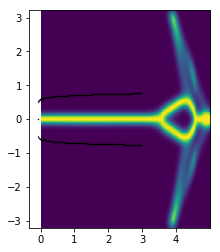

In [12]:
if nPosts == 2:
    fig, ax = plt.subplots(1, 1, figsize=(post0_x/2.5,post1_y/1.25))
    plt.imshow(img, extent=[0, post0_x, post0_y, post1_y])
else:
    plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

parameters = params1[0]
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = (
    np.arange(parameters[0], post0_x-0.2, step_len)
    if nPosts == 2
    else np.arange(parameters[0], 3., step_len)
)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    ((parameters[2] * (x - parameters[0])) ** parameters[1], -(parameters[2] * (x - parameters[0])) ** parameters[1])
)

if nPosts != 2:
    bisector_xs = [np.median(params1, axis=0)[0], post2_x]
    bisector_ys = [
        0,
        np.tan(np.arctan2(post2_y, post2_x - np.min(params1, axis=0)[0]) / 2)
        * (post2_x - np.min(params1, axis=0)[0]),
    ]

plt.xticks([0,1,2,3,4])
plt.scatter(x1, y1, c="black", s=0.1)
plt.scatter(x2, y2, c="black", s=0.1)
#plt.vlines(params1[0][0], post0_y, -post0_y, colors='white', linestyles='dashed')


# lx = x
# ly = (x - np.median(params1, axis=0)[0]) ** np.median(params1, axis=0)[1]
# lx = lx[np.where(np.isnan(ly) == False)[0]]
# ly = ly[np.where(np.isnan(ly) == False)[0]]
    
if nPosts == 2:
    fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/coll_density_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')

In [13]:
if nPosts == 2:
    print(
        "The bifurcation occurs at an angle",
        2 * np.arctan2(post1_y, post1_x - np.median(params1, axis=0)[0]) * 180 / np.pi,
    )
else:
    print(
        "The first bifurcation occurs at an angle",
        2 * np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) * 180 / np.pi,
    )

The first bifurcation occurs at an angle 78.71290695596882


#### Get the second bifurcation point
For this, you must center the trajectories about the bifurcation point, get a new heatmap and rotate this by the angle of the bisector line

In [14]:
# center points about the first bifurcation
cxs = xs - np.median(params1, axis=0)[0]
cys = ys

cpost0_x = post0_x - np.median(params1, axis=0)[0]
cpost1_x = post1_x - np.median(params1, axis=0)[0]
cpost2_x = post2_x - np.median(params1, axis=0)[0]

In [15]:
@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


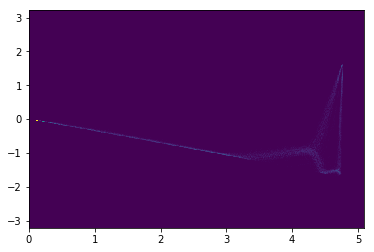

In [16]:
# clip all points to the left of and below 0 and points beyond post centers
ccxs = cxs[
    np.where(cxs > 0)[0]
]
ccys = cys[np.where(cxs > 0)[0]]
ccxs = ccxs[np.where(ccys > 0)[0]]
ccys = ccys[np.where(ccys > 0)[0]]

xy = np.concatenate((ccxs.reshape(-1, 1), ccys.reshape(-1, 1)), axis=1)
angle = np.full(
    ccxs.shape, np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
)
rmat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T
rx, ry = parallel_rotate(xy, rmat).T

blur = (51,51)

r1 = [[0, post1_x], [post0_y, post2_y]]
r2 = [
    [-np.median(params1, axis=0)[0], post1_x - np.median(params1, axis=0)[0]],
    [post0_y, post2_y],
]
r3 = [[0, post1_x - np.median(params1, axis=0)[0]], [post0_y, post2_y]]

h1, xedge, yedge, image = plt.hist2d(xs, ys, bins=nbins, normed=True, range=r1)
h2, xedge, yedge, image = plt.hist2d(cxs, cys, bins=nbins, normed=True, range=r2)
h3, xedge, yedge, image = plt.hist2d(
    ccxs, ccys, bins=nbins, normed=True, range=r3
)
h4, xedge, yedge, image = plt.hist2d(rx, ry, bins=nbins, normed=True, range=r3)

tmp_img1 = np.flipud(np.rot90(cv2.GaussianBlur(h1, blur, 0)))
tmp_img2 = np.flipud(np.rot90(cv2.GaussianBlur(h2, blur, 0)))
tmp_img3 = np.flipud(np.rot90(cv2.GaussianBlur(h3, blur, 0)))
tmp_img4 = np.flipud(np.rot90(cv2.GaussianBlur(h4, blur, 0)))

for i in range(0, nbins):
    max_val = np.max(tmp_img1[:, i])
    tmp_img1[:, i] = tmp_img1[:, i] / max_val
    max_val = np.max(tmp_img2[:, i])
    tmp_img2[:, i] = tmp_img2[:, i] / max_val
    max_val = np.max(tmp_img3[:, i])
    tmp_img3[:, i] = tmp_img3[:, i] / max_val
    max_val = np.max(tmp_img4[:, i])
    tmp_img4[:, i] = tmp_img4[:, i] / max_val

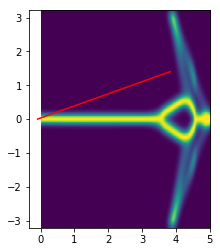

In [17]:
plt.imshow(tmp_img1, extent=[r1[0][0], r1[0][1], r1[1][0], r1[1][1]])
plt.plot(bisector_xs, bisector_ys, c="red")

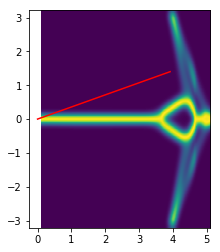

In [18]:
plt.imshow(tmp_img2, extent=[r2[0][0], r2[0][1], r2[1][0], r2[1][1]])
plt.plot(bisector_xs - np.median(params1, axis=0)[0], bisector_ys, c="red")

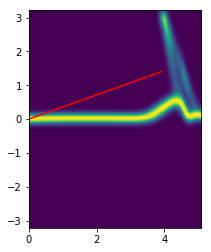

In [19]:
plt.imshow(np.flipud(tmp_img3), extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])
plt.plot(bisector_xs - np.median(params1, axis=0)[0], bisector_ys, c="red")

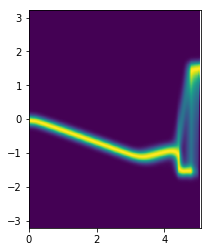

In [20]:
plt.imshow(np.flipud(tmp_img4), extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])

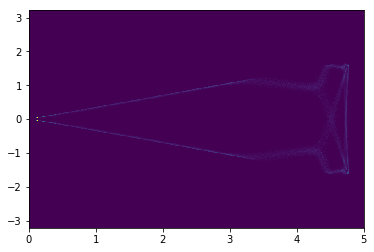

In [21]:
params2 = np.zeros((1, 3))

x_fit = []
y_fit = []

x_sub = np.concatenate((rx, rx))
y_sub = np.concatenate((ry, -ry))

tmp_img = density_map(x_sub, y_sub, stats=True)
x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
y_fit = (
    np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y
)

x_fit = x_fit
y_fit = np.abs(y_fit)

fit_params, pcov = curve_fit(
    fitfunc_vec_self, x_fit, y_fit, p0=[2, 1, 1], maxfev=10000
)
params2[0, :] = fit_params

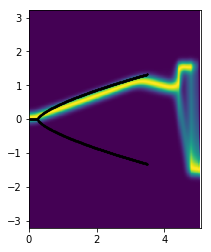

In [22]:
plt.imshow(tmp_img4, extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])

parameters = params2[0]
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = np.arange(parameters[0], 3.5, step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    ((parameters[2] * (x - parameters[0])) ** parameters[1], -(parameters[2] * (x - parameters[0])) ** parameters[1])
)

plt.scatter(x1, y1, c="black", s=1)
plt.scatter(x2, y2, c="black", s=1)

In [23]:
bif2 = np.array([np.median(params2, axis=0)[0], 0]).reshape(1, -1)
ang = angle[0]
rmat1 = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]]).T
bif2 = parallel_rotate(bif2, rmat).T
bif2[0] += np.median(params1, axis=0)[0]

In [24]:
print(
    "The second bifurcation occurs at angle",
    (
        (
            np.arctan2(post2_y - bif2[1], post2_x - bif2[0])
            - np.arctan2(bif2[1] - post1_y, post1_x - bif2[0])
        )
        * 180
        / np.pi
    )[0],
)

The second bifurcation occurs at angle 42.77738080619305


In [25]:
x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))
bcxy1 = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1)), axis=1)
ang1 = np.full(
    x1.shape, -np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
)
rmat1 = np.array([[np.cos(ang1), -np.sin(ang1)], [np.sin(ang1), np.cos(ang1)]]).T
bcx1, bcy1 = parallel_rotate(bcxy1, rmat1).T
bx1 = bcx1 + np.median(params1, axis=0)[0]

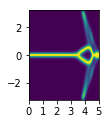

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(1.25,post2_x/2))
plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

step_len = 0.01
parameters = params2[0]

x1 = np.arange(step_len, parameters[1], step_len)
y1 = np.zeros(len(x1))
bcxy1 = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1)), axis=1)
ang1 = np.full(
    x1.shape, -np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
)
rmat1 = np.array([[np.cos(ang1), -np.sin(ang1)], [np.sin(ang1), np.cos(ang1)]]).T
bcx1, bcy1 = parallel_rotate(bcxy1, rmat1).T
bx1 = bcx1 + np.median(params1, axis=0)[0]

x = np.arange(parameters[0], 3.5, step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1], 
        -(parameters[2] * (x - parameters[0])) ** parameters[1])
)
bcxy2 = np.concatenate((x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
ang2 = np.full(
    x2.shape, -np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
)
rmat2 = np.array([[np.cos(ang2), -np.sin(ang2)], [np.sin(ang2), np.cos(ang2)]]).T
bcx2, bcy2 = parallel_rotate(bcxy2, rmat2).T
bx2 = bcx2 + np.median(params1, axis=0)[0]

bx2 = np.concatenate((bx2, bx2))
bcy2 = np.concatenate((bcy2, -bcy2))

bcy2 = bcy2[np.where(bx2 < post1_x-0.1)[0]]
bx2 = bx2[np.where(bx2 < post1_x-0.1)[0]]

bx2 = bx2[np.where(np.abs(bcy2) < post2_y-0.1)[0]]
bcy2 = bcy2[np.where(np.abs(bcy2) < post2_y-0.1)[0]]

#plt.scatter(bx2, bcy2, c="black", s=0.1)

parameters = params1[0]
step_len = 0.01

x1 = np.arange(5*step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = np.arange(parameters[0], np.min(bx2), step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1], 
        -(parameters[2] * (x - parameters[0])) ** parameters[1],
    )
)

#plt.scatter(x1, y1, c="black", s=0.1)
#plt.scatter(x2, y2, c="black", s=0.1)
plt.xticks([0,1,2,3,4,5])
#plt.vlines(params1[0][0], post0_y, -post0_y, colors='white', linestyles='dashed')
#plt.vlines(np.min(bx2), post0_y, -post0_y, colors='white', linestyles='dashed') 
    
fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/density_n' + str(nPosts) + '_cosine.pdf', dpi=600, bbox_inches='tight')